<font color = 'Orange' size = 6> LandUse Dataset trained with ENET_b0 Architecture</font>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
import os
helper_methods_folder = '/content/drive/MyDrive/AI Project/helper_methods'

sys.path.append(os.path.abspath(helper_methods_folder))

**Importing helper methods for preprocessing, training and plotting**

In [3]:
from preprocessing import load_data
from plots import plot_data_loader, show_examples
from plots import plot_accuracy, plot_loss,plot_training_batch_loss, plot_confusion_matrix
from training import train_model, compute_accuracy_and_loss
from early_stopping import EarlyStopping
from metrics import compute_classification_report, compute_confusion_matrix
from unnormalize_images import UnNormalize
from predictions import predict_image_class

**Importing Libraries**

In [4]:
from torchvision import models
import torch.nn as nn
import torch
import matplotlib.pyplot as plt


In [5]:
root_dir = r'/content/drive/MyDrive/archive/images'
path_to_save_model=r"/content/drive/MyDrive/AI Project/LandUseResults"
file_name = "landuse_dataset_ENET1"

**Load the datasets into train_loader, validation loader and test loader**

In [6]:
train_loader, test_loader, valid_loader, data = load_data(root_dir, test_split=0.2, val_split=0.1, batch_size=32, input_size=[128,128])

In [7]:
# checking the train loader dataset information
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

Image batch dimensions: torch.Size([32, 3, 128, 128])
Image label dimensions: torch.Size([32])
Class labels of 10 examples: tensor([14,  2,  7,  7,  3, 11,  5, 10,  1, 13])


**Encodings for the classes**

In [8]:
label_encoding = data.class_to_idx  
print("label mapping is ", label_encoding)   # save these mapping for predicition  

label mapping is  {'agricultural': 0, 'airplane': 1, 'baseballdiamond': 2, 'beach': 3, 'buildings': 4, 'chaparral': 5, 'denseresidential': 6, 'forest': 7, 'freeway': 8, 'golfcourse': 9, 'harbor': 10, 'intersection': 11, 'mediumresidential': 12, 'mobilehomepark': 13, 'overpass': 14, 'parkinglot': 15, 'river': 16, 'runway': 17, 'sparseresidential': 18, 'storagetanks': 19, 'tenniscourt': 20}


**Plot the data loader**

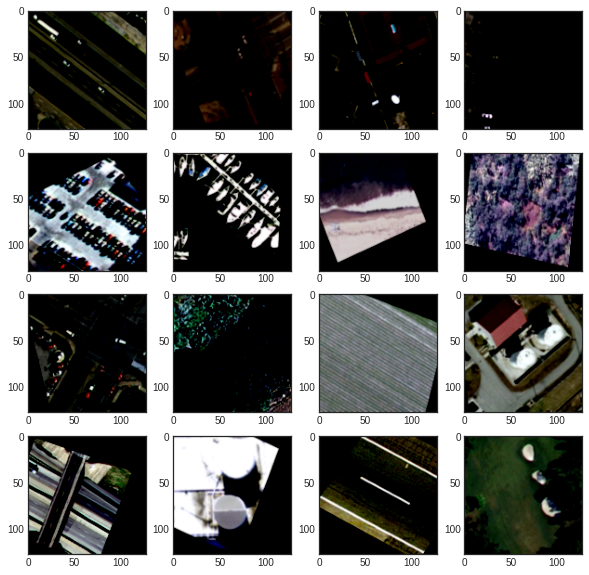

In [9]:
plot_data_loader(train_loader, (4,4))

**Load ENET_b0 Model** 

In [10]:
model = models.efficientnet_b0(pretrained=False)  # By default, no pre-trained weights are used.
print(model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


**Change the number of outputs classes in the last layer of the model**

In [12]:
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 21)  #num_classes = 21
print(model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

**Set the hyperparameters**

In [13]:
# define the loss function for multi-class classifictaion
criterion = nn.CrossEntropyLoss()

# criterion = torch.nn.functional.cross_entropy
#Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 3, verbose=False)

# create and early stopping object which will be used during the training
early_stopping = EarlyStopping(tolerance=3, min_delta=0.01)

num_epochs = 40

**Train the Model with train_loader and perform validation with valid_loader**

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
print("Device: {}".format(device))

model.to(device)

minibatch_loss_list, train_acc_list, valid_acc_list, train_loss_list, valid_loss_list = train_model(
    model=model,
    num_epochs=num_epochs,
    train_loader=train_loader,
    valid_loader=valid_loader,
    criterion = criterion,
    optimizer=optimizer,
    device=device,
    early_stopping=early_stopping,
    file_name = file_name,
    path_to_save_model=path_to_save_model,
    scheduler=scheduler)

Device: cuda:0
Epoch: 001/040 | Batch 0000/0230 | Loss: 3.0016
Epoch: 001/040 | Batch 0100/0230 | Loss: 2.8442
Epoch: 001/040 | Batch 0200/0230 | Loss: 2.6344
Epoch: 001/040 | Train ACC: 11.46% | Validation ACC: 15.62%| Train LOSS: 2.8697| Validation LOSS: 2.7282
Time elapsed: 64.42 min
Epoch: 002/040 | Batch 0000/0230 | Loss: 2.5072
Epoch: 002/040 | Batch 0100/0230 | Loss: 2.5435
Epoch: 002/040 | Batch 0200/0230 | Loss: 2.4310
Epoch: 002/040 | Train ACC: 20.83% | Validation ACC: 25.71%| Train LOSS: 2.5432| Validation LOSS: 2.3261
Time elapsed: 65.43 min
Epoch: 003/040 | Batch 0000/0230 | Loss: 2.2828
Epoch: 003/040 | Batch 0100/0230 | Loss: 2.3985
Epoch: 003/040 | Batch 0200/0230 | Loss: 2.5077
Epoch: 003/040 | Train ACC: 28.12% | Validation ACC: 28.86%| Train LOSS: 2.3206| Validation LOSS: 2.2473
Time elapsed: 66.42 min
Epoch: 004/040 | Batch 0000/0230 | Loss: 2.3539
Epoch: 004/040 | Batch 0100/0230 | Loss: 2.3543
Epoch: 004/040 | Batch 0200/0230 | Loss: 2.3798
Epoch: 004/040 | Train

**Test Accuracy and test loss**

In [15]:
test_acc, test_loss= compute_accuracy_and_loss(model, test_loader,criterion, device=device)
print(f'Test Accuracy {test_acc :.2f}%')
print(f'Test Loss {test_loss :.4f}')

Test Accuracy 79.14%
Test Loss 0.6252


**Plot the Training Mini_Batch_loss**

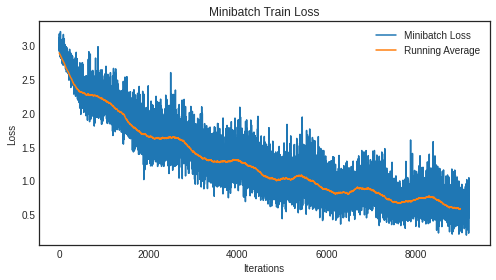

In [16]:
plot_training_batch_loss(minibatch_loss_list, num_epochs, len(train_loader))
plt.show()

**Plot train vs Validation Accuracy**

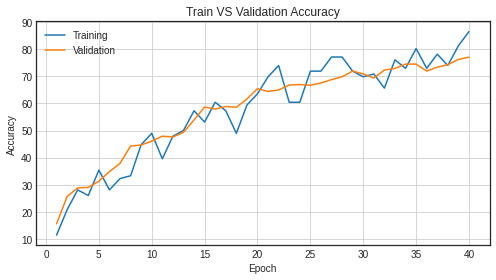

In [17]:
plot_accuracy(train_acc_list, valid_acc_list)
plt.show()

**Plot train vs Validation Loss**

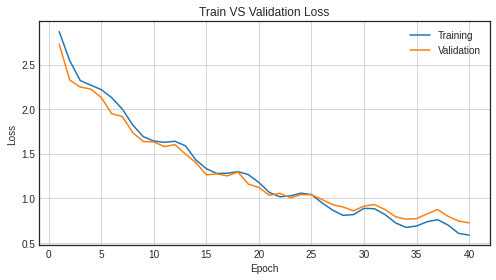

In [18]:
plot_loss(train_loss_list, valid_loss_list)
plt.show()

**Saving the loss and accuracy into file for later model comparison**

In [19]:
landuse_dataset_output_dict = {"train_acc_list":train_acc_list,"valid_acc_list":valid_acc_list, "train_loss_list":train_loss_list, "valid_loss_list": valid_loss_list}

import json 

#writing this dict to a file for later use
with open('landuse_dataset_enet1results.txt', 'w') as f:
    f.write(json.dumps(landuse_dataset_output_dict))


# for reading the file back into a Python object
# with open('./Satellite_dataset_results.txt, 'r') as f:
#     satellite_dataset_output_dict = json.loads(f.read())

**Confusion Matrix**

In [20]:
label_encoding = data.class_to_idx

class_dict = {v: k for k, v in label_encoding.items()} #reverse the mapping

print(label_encoding)

{'agricultural': 0, 'airplane': 1, 'baseballdiamond': 2, 'beach': 3, 'buildings': 4, 'chaparral': 5, 'denseresidential': 6, 'forest': 7, 'freeway': 8, 'golfcourse': 9, 'harbor': 10, 'intersection': 11, 'mediumresidential': 12, 'mobilehomepark': 13, 'overpass': 14, 'parkinglot': 15, 'river': 16, 'runway': 17, 'sparseresidential': 18, 'storagetanks': 19, 'tenniscourt': 20}


In [ ]:
# label_encoding = {'cloudy': 0, 'desert': 1, 'green_area': 2, 'water': 3}  # assign to a variable as it will be needed while prediciting

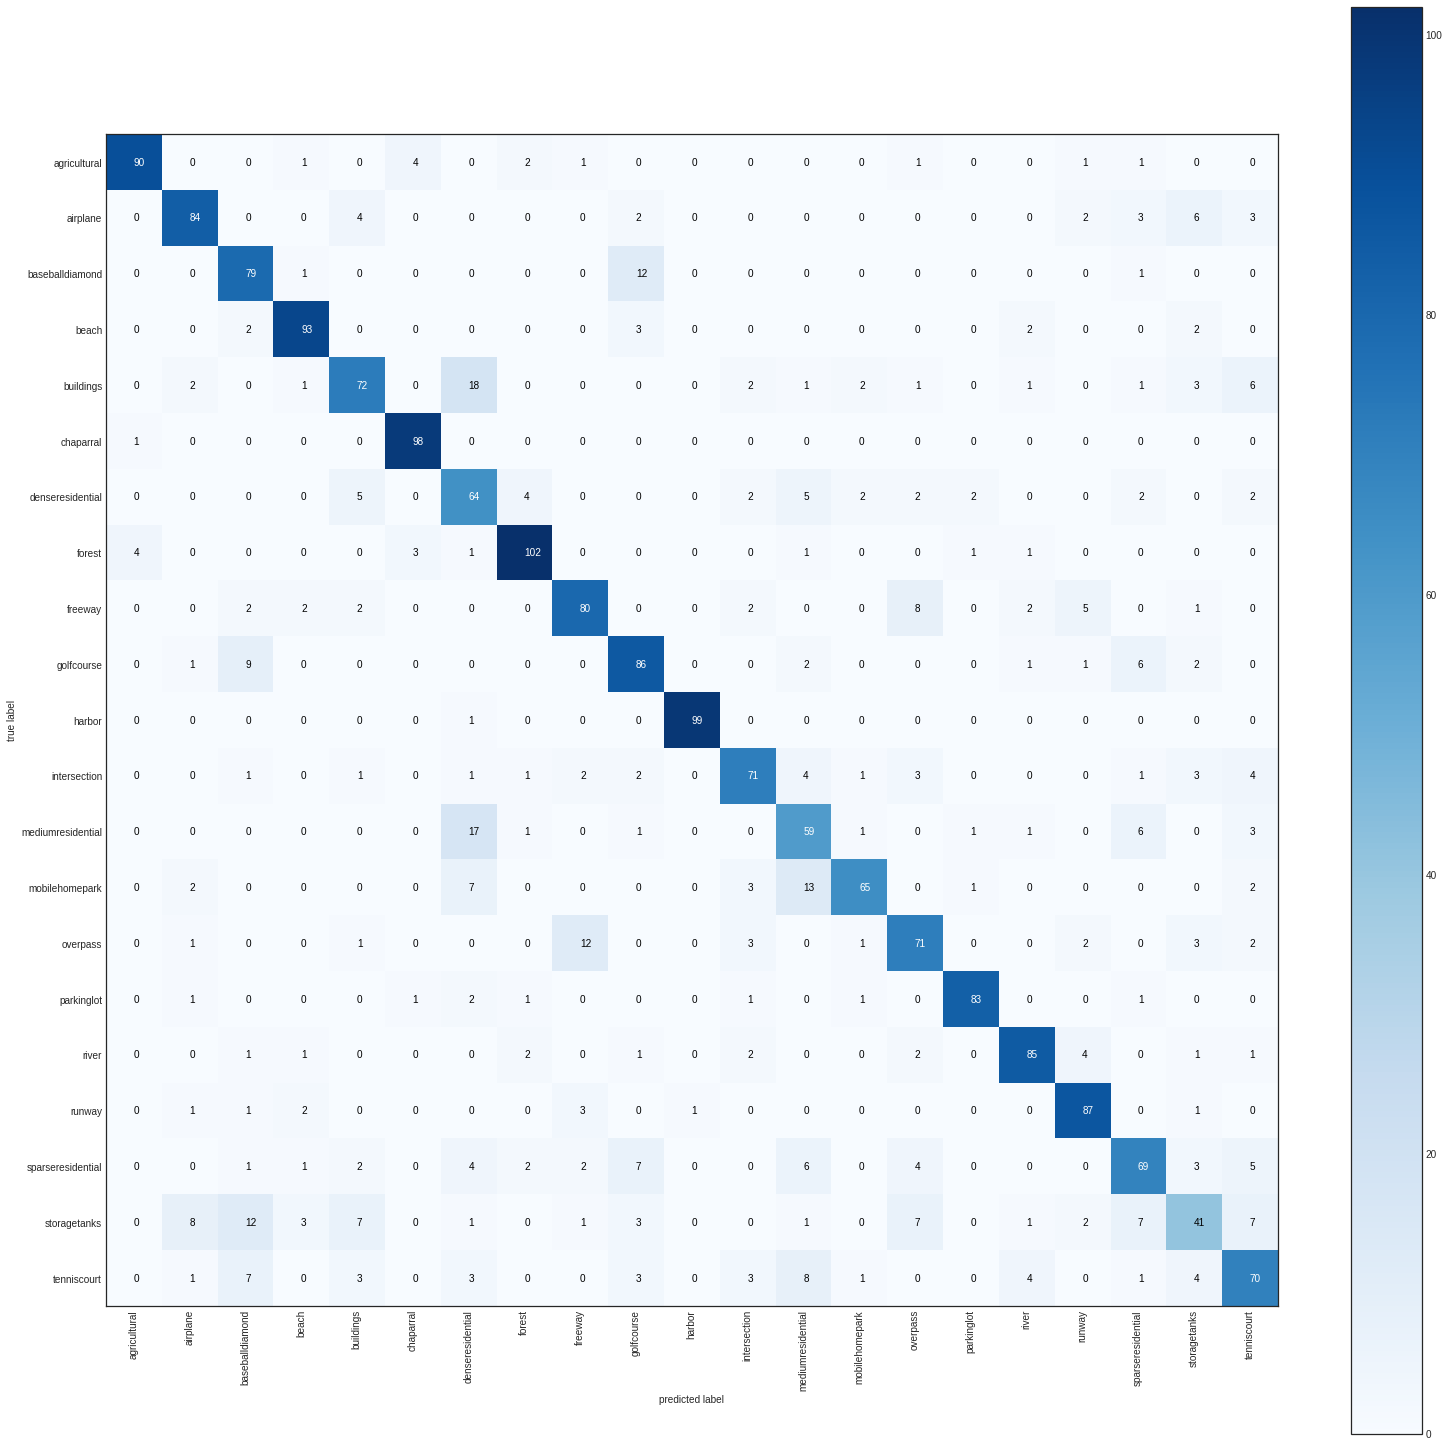

In [21]:
confusion_matrix = compute_confusion_matrix(model = model, data_loader = test_loader, device=torch.device('cuda:0'))
plot_confusion_matrix(confusion_matrix, class_names = class_dict.values())
plt.show()

**F1 Score, Precision and Recall**

In [22]:
print(compute_classification_report(test_loader, model, device=torch.device('cuda') ))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94        95
           1       0.83      0.84      0.83       102
           2       0.86      0.73      0.79       109
           3       0.93      0.85      0.89       112
           4       0.65      0.72      0.68        98
           5       0.99      0.95      0.97       103
           6       0.69      0.53      0.60       116
           7       0.96      0.90      0.93       120
           8       0.75      0.78      0.76       100
           9       0.76      0.73      0.75       112
          10       0.99      0.97      0.98       102
          11       0.69      0.75      0.72        88
          12       0.62      0.57      0.59        99
          13       0.74      0.91      0.82        76
          14       0.72      0.65      0.68       106
          15       0.93      0.91      0.92        93
          16       0.82      0.91      0.86        90
          17       0.94    

**Predicted labels Visualization**

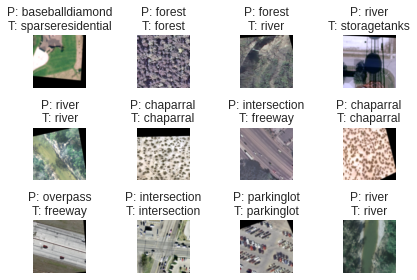

In [23]:
model.cpu()
unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

show_examples(model=model, data_loader=test_loader, unnormalizer=unnormalizer, class_dict=class_dict)

**Load the saved model to make predictions**

In [24]:
model  = torch.load(path_to_save_model + file_name+'_FINAL_MODEL_WEIGHTS.pth', map_location=torch.device('cpu'))

In [25]:
# test image path 
img_path = '/content/drive/MyDrive/AI Project/buildings.png'

In [26]:
classes = ['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings', 'chaparral', 'denseresidential', 'forest', 'freeway', 'golfcourse', 'harbor', 'intersection', 'mediumresidential', 'mobilehomepark', 'overpass', 'parkinglot', 'river', 'runway', 'sparseresidential', 'storagetanks', 'tenniscourt']
print("The predicted class is " , predict_image_class(model, img_path, classes))

The predicted class is  river
